# This notebook contains code for obtaining EC Results:

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
print('Tensorflow version = ',tf.__version__)

import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score, precision_score,balanced_accuracy_score,roc_auc_score,roc_curve

import ML_models

Tensorflow version =  2.1.0


# Key parameters: 

In [2]:
dz = 3

batch_size = 512
ClassWeights1=[0.16,1.0] #different to CRC
ClassWeights2=[0.16,1.0] #different to CRC

Per_spectra_thresh = 0.5
TissueGroupThreshold = 0.5

# Load metadata and preprepared imzML binned data:

In [4]:
imzML_df = pd.read_hdf('BinnedData/Tuebingen_Jan2021_dz'+str(dz)+'_df.h5') #number of rows = number of patients
imzML_df = imzML_df.replace(np.nan, '', regex=True)
NumSpectra = []
for i in range(imzML_df.shape[0]):
    NumSpectra.append(imzML_df.iloc[i]['binned_data'][0].shape[0])
Spectra_per_sample = [len(i[0]) for i in imzML_df['binned_data'].values]
imzML_df['label'].value_counts()

negative    274
positive     52
Name: label, dtype: int64

# Functions for creating train and validation splits:

In [5]:
def CreateTrainOrValArrays(The_df):
    X_data0 = []
    Y_data0 = []
    for ind in range(The_df.shape[0]):
        if len(The_df['binned_data'].values[ind])!=0:
            X_data0.append(The_df['binned_data'].values[ind][0])
            if The_df['label'].values[ind]=='negative':
                Y_data0.append(np.zeros(The_df['binned_data'].values[ind][0].shape[0],'uint8'))
            elif The_df['label'].values[ind]=='positive':
                Y_data0.append(np.ones(The_df['binned_data'].values[ind][0].shape[0],'uint8'))
            else:
                print('error')
    X = np.concatenate(X_data0,axis=0)
    Y = np.concatenate(Y_data0,axis=0)
    return X,Y

# Loop over each cross-validation split and train models:

In [6]:
#we want to create val and train splits by patient, so split the dataframe first
NumFolds=10
NumEachClassInVal=10
UniquePatients = imzML_df['patient'].unique()
UniquePositivePatients = np.unique(imzML_df[imzML_df['label']=='positive']['patient'])
UniqueNegativePatients = np.unique(imzML_df[imzML_df['label']=='negative']['patient'])
NumNegativePatients = len(UniqueNegativePatients)
NumPositivePatients = len(UniquePositivePatients)
print(len(UniquePatients),NumNegativePatients,NumPositivePatients)
Positive_df = imzML_df[imzML_df['patient'].isin(UniquePositivePatients)]
Negative_df = imzML_df[imzML_df['patient'].isin(UniqueNegativePatients)]
CrossValidationModels1=[]
CrossValidationModels2=[]
AllPredictions1=[]
AllPredictions2=[]
Val_sets=[]
Val_positive_dfs=[]
Val_negative_dfs=[]
for Fold_ID in range(NumFolds):
    start = time.time()
    np.random.shuffle(UniquePositivePatients)
    np.random.shuffle(UniqueNegativePatients)
    Val_Positive_df=Positive_df[Positive_df['patient'].isin(UniquePositivePatients[0:NumEachClassInVal])]
    Val_Negative_df=Negative_df[Negative_df['patient'].isin(UniqueNegativePatients[0:NumEachClassInVal])]
    Train_Positive_df=Positive_df[Positive_df['patient'].isin(UniquePositivePatients[NumEachClassInVal::])]
    Train_Negative_df=Negative_df[Negative_df['patient'].isin(UniqueNegativePatients[NumEachClassInVal::])]
    Val_Positive_df=Val_Positive_df.sort_values(by=['patient'])
    Train_Positive_df=Train_Positive_df.sort_values(by=['patient'])
    Val_Negative_df=Val_Negative_df.sort_values(by=['patient'])
    Train_Negative_df=Train_Negative_df.sort_values(by=['patient'])
    #convert from dataframes to numpy
    X_train_p,y_train_p = CreateTrainOrValArrays(Train_Positive_df)
    X_val_p,y_val_p = CreateTrainOrValArrays(Val_Positive_df)
    X_train_n,y_train_n = CreateTrainOrValArrays(Train_Negative_df)
    X_val_n,y_val_n = CreateTrainOrValArrays(Val_Negative_df)
    X_train = np.concatenate((X_train_p,X_train_n),axis=0)
    X_val = np.concatenate((X_val_p,X_val_n),axis=0)
    y_train = np.concatenate((y_train_p,y_train_n),axis=0)
    y_val = np.concatenate((y_val_p,y_val_n),axis=0)
    Val_positive_dfs.append(Val_Positive_df)
    Val_negative_dfs.append(Val_Negative_df)
    Val_sets.append(y_val)
    X_train = np.sqrt(X_train)
    X_val = np.sqrt(X_val)

    #create and train the models
    
    #1d conv net
    model1 = ML_models.ConvNet_1D(X_train,y_train,X_val,y_val,batch_size,ClassWeights1)
    CrossValidationModels1.append(model1)
    #MLP
    model2 = ML_models.NeuralNetwork(X_train,y_train,X_val,y_val,batch_size,ClassWeights2)
    CrossValidationModels2.append(model2)
    
    #run the models for this TMA on the validation data
    raw_pred1 = model1.predict(np.expand_dims(X_val,-1))
    AllPredictions1.append(raw_pred1)
    raw_pred2 = model2.predict(X_val)
    AllPredictions2.append(raw_pred2)
    end = time.time()
    print('train time = ',end - start)


251 209 42
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30234 samples, validate on 2574 samples
Epoch 1/5
30234/30234 [==============================] - 7s 227us/sample - loss: 0.7001 - accuracy: 0.7472 - val_loss: 1.3176 - val_accuracy: 0.4588
Epoch 2/5
30234/30234 [==============================] - 1s 48us/sample - loss: 0.5603 - accuracy: 0.7938 - val_loss: 1.2249 - val_accuracy: 0.4588
Epoch 3/5
30234/30234 [==============================] - 1s 48us/sample - loss: 0.4555 - accuracy: 0.8055 - val_loss: 0.9755 - val_accuracy: 0.4650
Epoch 4/5
30234/30234 [==============================] - 1s 48us/sample - loss: 0.3837 - accuracy: 0.8063 - val_loss: 1.4717 - val_accuracy: 0.4588
Epoch 5/5
30234/30234 [==============================] - 1s 48us/sample - loss: 0.3180 - accuracy: 0.8163 - val_loss: 0.9925 - val_accuracy: 0.4577
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30234 samples, validate on 2574 samples
Epoch 6/10
30234/30234 [==========================

30131/30131 [==============================] - 4s 139us/sample - loss: 0.2321 - accuracy: 0.9227 - val_loss: 0.8508 - val_accuracy: 0.8192
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30131 samples, validate on 2677 samples
Epoch 25/25
30131/30131 [==============================] - 0s 9us/sample - loss: 0.0940 - accuracy: 0.7643 - val_loss: 0.5817 - val_accuracy: 0.8928
train time =  35.58808660507202
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 29865 samples, validate on 2943 samples
Epoch 1/5
29865/29865 [==============================] - 5s 163us/sample - loss: 0.7166 - accuracy: 0.7096 - val_loss: 1.0876 - val_accuracy: 0.5151
Epoch 2/5
29865/29865 [==============================] - 1s 49us/sample - loss: 0.5759 - accuracy: 0.7685 - val_loss: 0.7454 - val_accuracy: 0.7608
Epoch 3/5
29865/29865 [==============================] - 1s 48us/sample - loss: 0.470

30020/30020 [==============================] - 1s 48us/sample - loss: 0.2674 - accuracy: 0.8819 - val_loss: 0.4699 - val_accuracy: 0.6026
Epoch 8/10
30020/30020 [==============================] - 1s 49us/sample - loss: 0.2584 - accuracy: 0.8901 - val_loss: 0.5065 - val_accuracy: 0.6011
Epoch 9/10
30020/30020 [==============================] - 1s 49us/sample - loss: 0.2508 - accuracy: 0.8982 - val_loss: 0.5196 - val_accuracy: 0.6144
Epoch 10/10
30020/30020 [==============================] - 1s 49us/sample - loss: 0.2437 - accuracy: 0.9052 - val_loss: 0.5533 - val_accuracy: 0.5656
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30020 samples, validate on 2788 samples
Epoch 11/11
30020/30020 [==============================] - 4s 142us/sample - loss: 0.2357 - accuracy: 0.9144 - val_loss: 0.6194 - val_accuracy: 0.5890
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30020

30126/30126 [==============================] - 1s 48us/sample - loss: 0.4670 - accuracy: 0.8030 - val_loss: 0.7593 - val_accuracy: 0.6316
Epoch 4/5
30126/30126 [==============================] - 1s 48us/sample - loss: 0.3875 - accuracy: 0.8169 - val_loss: 0.5956 - val_accuracy: 0.7793
Epoch 5/5
30126/30126 [==============================] - 1s 48us/sample - loss: 0.3211 - accuracy: 0.8395 - val_loss: 0.5238 - val_accuracy: 0.7666
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30126 samples, validate on 2682 samples
Epoch 6/10
30126/30126 [==============================] - 5s 169us/sample - loss: 0.2779 - accuracy: 0.8724 - val_loss: 0.4717 - val_accuracy: 0.8087
Epoch 7/10
30126/30126 [==============================] - 1s 48us/sample - loss: 0.2651 - accuracy: 0.8929 - val_loss: 0.4668 - val_accuracy: 0.7968
Epoch 8/10
30126/30126 [==============================] - 1s 48us/sample - loss: 0.2566 - accuracy: 0.9000 - val_loss: 0.4418 - val_accuracy: 0.8136
Epoch 9/10
30126/30

# Results for classification of spectra:

In [7]:
Accs=[]
BalAccs=[]
Sens=[]
Specs=[]
AUCs=[]
AUC_tprs =[]
AUC_fprs =[]
AUC_thresholds =[]
cc=0
for ID in range(NumFolds):
    #for EC, instead of averaging the model predictions, use model2 only for better results
    raw_pred=0*np.squeeze(AllPredictions1[cc])/2+2*np.squeeze(AllPredictions2[cc])/2
    ###########################################################################################
    #get TPR v TNR curve
    ###########################################################################################
    fpr, tpr, thresholds = roc_curve(Val_sets[cc], raw_pred)
    AUC_tprs.append(tpr)
    AUC_fprs.append(fpr)
    AUC_thresholds.append(thresholds)
    ###########################################################################################
    #get per-spectra metrics
    ###########################################################################################
    y_pred = (raw_pred>Per_spectra_thresh).astype('uint8')
    Overall_accuracy = accuracy_score(Val_sets[cc], y_pred)
    conf_matrix = confusion_matrix(Val_sets[cc],y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(Val_sets[cc], y_pred)
    AUC = roc_auc_score(Val_sets[cc], raw_pred)
    Accs.append(Overall_accuracy)
    BalAccs.append(Balanced_accuracy)
    Sens.append(Sensitivity)
    Specs.append(Specificity)
    AUCs.append(AUC)
    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))
    cc+=1
plt.show()

Confusion Matrix: 
[[716 465]
 [434 959]]
Validation Accuracy: 65.07%
Validation Sensitivity: 68.84%
Validation Specificity: 60.63%
Validation Balanced accuracy: 64.74%
Validation AUC: 0.6719
Confusion Matrix: 
[[1048  240]
 [ 286 1055]]
Validation Accuracy: 79.99%
Validation Sensitivity: 78.67%
Validation Specificity: 81.37%
Validation Balanced accuracy: 80.02%
Validation AUC: 0.8824
Confusion Matrix: 
[[1203   74]
 [ 213 1187]]
Validation Accuracy: 89.28%
Validation Sensitivity: 84.79%
Validation Specificity: 94.21%
Validation Balanced accuracy: 89.50%
Validation AUC: 0.9251
Confusion Matrix: 
[[ 987  529]
 [ 175 1252]]
Validation Accuracy: 76.08%
Validation Sensitivity: 87.74%
Validation Specificity: 65.11%
Validation Balanced accuracy: 76.42%
Validation AUC: 0.8276
Confusion Matrix: 
[[790 432]
 [119 808]]
Validation Accuracy: 74.36%
Validation Sensitivity: 87.16%
Validation Specificity: 64.65%
Validation Balanced accuracy: 75.91%
Validation AUC: 0.7384
Confusion Matrix: 
[[ 787  8

# Print average metrics:

In [8]:
print('Average accuracy: ',np.mean(Accs))
print('Average balanced accuracy: ',np.mean(BalAccs))
print('Average sensitivity: ',np.mean(Sens))
print('Average specificity: ',np.mean(Specs))
print('Average AUC: ',np.mean(AUCs))
min(AUCs),max(AUCs)

Average accuracy:  0.7868716850578891
Average balanced accuracy:  0.7938571544556079
Average sensitivity:  0.8509579932659527
Average specificity:  0.7367563156452632
Average AUC:  0.840844533969926


(0.6718526708782815, 0.9267423781481263)

# Figure for TPR v TNR:

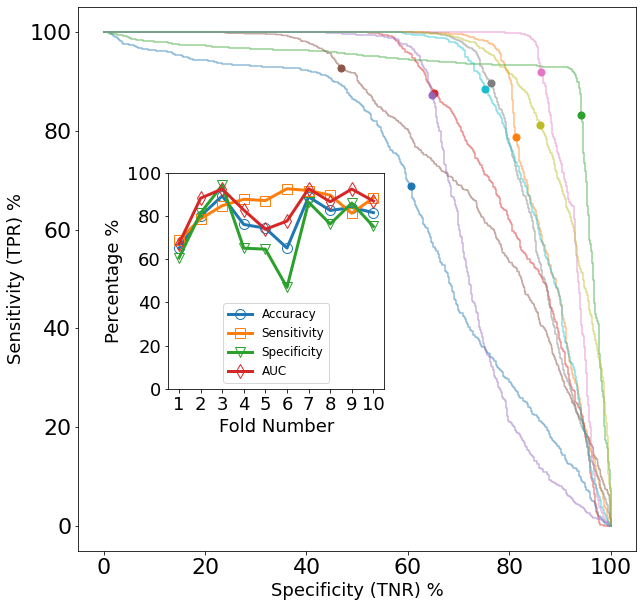

In [9]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
for j in range(len(AUC_tprs)):
    plt.plot(100.0-100*AUC_fprs[j],100*AUC_tprs[j],alpha=0.5)
    #find fpr and tpr for threshold Per_spectra_thresh
    ind = min(range(len(AUC_thresholds[j])), key=lambda i: abs(AUC_thresholds[j][i]-Per_spectra_thresh))
    plt.scatter(100-100*AUC_fprs[j][ind],100*AUC_tprs[j][ind],s=50,marker='o')
    plt.ylabel('Sensitivity (TPR) %',fontsize=18)
plt.xlabel('Specificity (TNR) %',fontsize=18)
matplotlib.rcParams.update({'font.size': 12})
a = plt.axes([.25, .35, .3, .3])
plt.plot(100*np.array(Accs),'-o',markersize=10, label='Accuracy',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(Sens),'-s',markersize=10, label='Sensitivity',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(Specs),'-v',markersize=10, label='Specificity',markerfacecolor='none',linewidth=3)
plt.plot(100*np.array(AUCs),'-d',markersize=10, label='AUC',markerfacecolor='none',linewidth=3)
plt.xlim((-0.5,9.5))
plt.ylim((0,100))
plt.xticks(np.arange(10),[1,2,3,4,5,6,7,8,9,10],fontsize=18)#,rotation='vertical')
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100],fontsize=18)
plt.ylabel('Percentage %',fontsize=18)
plt.xlabel('Fold Number',fontsize=18)
plt.legend(loc="lower center")
plt.savefig('Figures/Experiment1_endo.pdf')
plt.show()

# Results for per-patient tissue groups in each validation fold:

In [10]:
ValPatientCounts=[]
ValPatientCorrectCounts=[]
ValPatientAccs=[]
PatientConfusionMatrix=np.zeros((2,2),dtype='uint16')
CC=0
AllSigs0=[]
AllSigs1=[]
for ID in range(NumFolds):
    Val_positive_df=Val_positive_dfs[CC]
    Val_negative_df=Val_negative_dfs[CC]
    Val_df=Val_positive_df.append(Val_negative_df)
    model1 = CrossValidationModels1[CC]
    model2 = CrossValidationModels2[CC]
    TissueGroupCountCorrect = 0
    TissueGroupCount = 0
    UniquePatients = np.unique(Val_df['patient'])
    for patient in UniquePatients:
        ThisPatient_df=Val_df[Val_df['patient']==patient]
        TissueGroupCount=TissueGroupCount+1
        X_val,Y_val = CreateTrainOrValArrays(ThisPatient_df)
        X_val = np.sqrt(X_val)
        raw_pred=0*np.squeeze(model1.predict(np.expand_dims(X_val,-1)))/2+2*np.squeeze(model2.predict(X_val))/2
        Sig = np.median(raw_pred)
        if Sig<TissueGroupThreshold:
            if Y_val[0]==0:
                AllSigs0.append(Sig)
                TissueGroupCountCorrect=TissueGroupCountCorrect+1
                PatientConfusionMatrix[0,0] += 1
            else:
                AllSigs1.append(Sig)
                PatientConfusionMatrix[1,0] += 1
        else:
            if Y_val[0]==1:
                TissueGroupCountCorrect=TissueGroupCountCorrect+1
                PatientConfusionMatrix[1,1]+=1
                AllSigs1.append(Sig)
            else:
                PatientConfusionMatrix[0,1] += 1
                AllSigs0.append(Sig)
    print(TissueGroupCountCorrect/TissueGroupCount)
    ValPatientCounts.append(TissueGroupCount)
    ValPatientCorrectCounts.append(TissueGroupCountCorrect)
    ValPatientAccs.append(TissueGroupCountCorrect/TissueGroupCount)
    CC+=1
PatientConfusionMatrix

0.75
0.9
0.85
0.75
0.8
0.8
0.9
0.8
0.9
0.9


array([[73, 27],
       [ 6, 94]], dtype=uint16)

# Per patient stats:

In [11]:
print(sum(ValPatientCounts),sum(ValPatientCorrectCounts),np.mean(ValPatientAccs))
print(PatientConfusionMatrix)
print('False positives = ',PatientConfusionMatrix[0,1])
print('False negatives = ',PatientConfusionMatrix[1,0])

200 167 0.8350000000000002
[[73 27]
 [ 6 94]]
False positives =  27
False negatives =  6


# Final Figures:

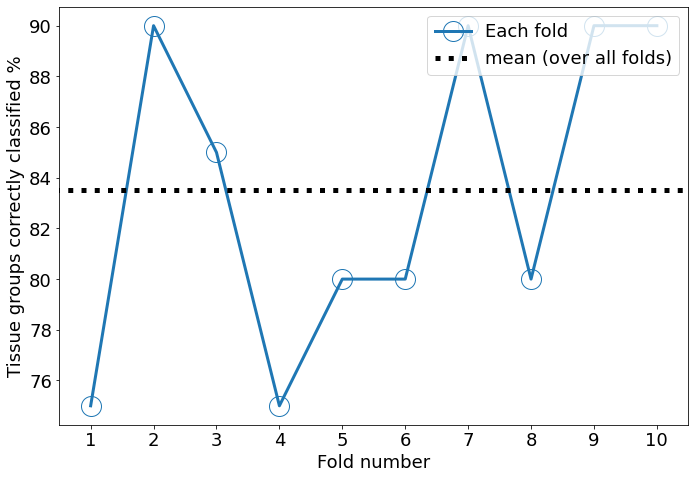

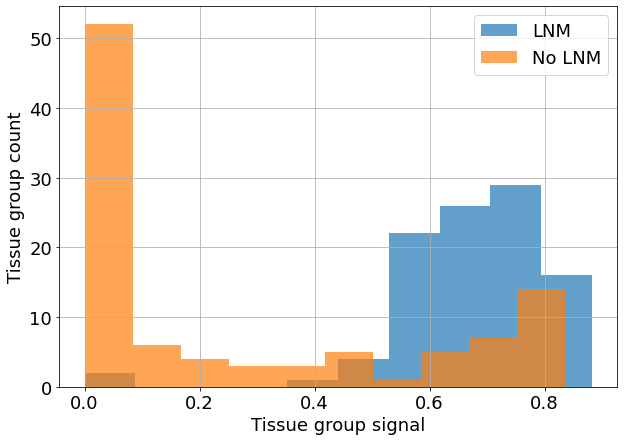

In [12]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,7))
plt.plot(100*np.array(ValPatientAccs),'-o',markersize=20, label='Each fold',markerfacecolor='none',linewidth=3)
plt.plot(np.arange(-1,16),100*np.mean(ValPatientAccs)*np.ones(17),'black', linestyle=':',label='mean (over all folds)',linewidth=5)
plt.xlim((-0.5,9.5))
plt.xticks(np.arange(NumFolds),np.arange(1,1+NumFolds))
plt.ylabel('Tissue groups correctly classified %',fontsize=18)
plt.xlabel('Fold number',fontsize=18)
plt.legend(loc="upper right")
plt.tight_layout() #need this or xticks get cut off
plt.savefig('Figures/Experiment2a_endo.pdf')
plt.show()
#plot histograms of the ML based signal for 
fig = plt.figure(figsize = (10,7))
ax = fig.gca()
pd.DataFrame(AllSigs1).hist(ax=ax,bins=10,alpha=0.7,label='LNM')
pd.DataFrame(AllSigs0).hist(ax=ax,bins=10,alpha=0.7,label='No LNM')
plt.xlabel('Tissue group signal',fontsize=18)
plt.ylabel('Tissue group count',fontsize=18)
plt.legend(loc="upper right")
plt.title('')
fig.gca().set_rasterized(True)
plt.savefig('Figures/Experiment2b_endo.pdf')
plt.show()